In [1]:
# Basic setup: imports and SQLite connection
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DB_PATH = "../data/weather.db"  # adjust if notebook sits elsewhere

conn = sqlite3.connect(DB_PATH)
pd.options.display.float_format = "{:,.2f}".format

In [5]:
row_count = pd.read_sql("SELECT COUNT(*) AS rows FROM weather_daily", conn)
latest = pd.read_sql("SELECT MAX(date) AS latest_date FROM weather_daily", conn)

row_count, latest

(   rows
 0    32,
   latest_date
 0  2025-08-23)

Snapshot for a single day (all regions)

In [4]:
# Fetch one-day snapshot for all regions (replace date if needed)
DATE = "2025-08-22"

day_df = pd.read_sql(
    """
    SELECT region, date, latitude, longitude,
           temperature_2m_max, temperature_2m_min,
           precipitation_sum, wind_speed_10m_max
    FROM weather_daily
    WHERE date = ?
    ORDER BY region
    """,
    conn,
    params=[DATE],
)

# Convert to proper dtypes
day_df["date"] = pd.to_datetime(day_df["date"], errors="coerce")

day_df.head()


,region,date,latitude,longitude,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max
0,dolnoslaskie,2025-08-22,51.10,17.04,19.80,13.90,0.00,16.60
1,kujawsko_pomorskie,2025-08-22,53.12,18.00,19.90,12.50,0.00,21.50
2,lodzkie,2025-08-22,51.76,19.45,20.50,15.80,0.00,18.70
3,lubelskie,2025-08-22,51.24,22.55,23.70,16.40,0.00,21.20
4,lubuskie,2025-08-22,51.94,15.50,19.50,11.80,0.00,18.60


Bar chart – max temperature by region (that day):

<Figure size 1200x500 with 0 Axes>

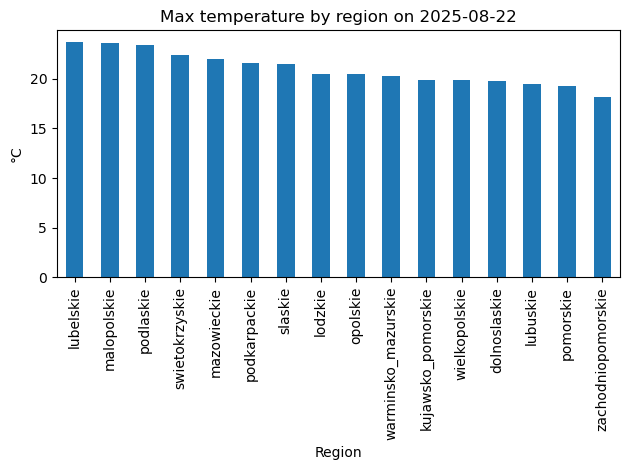

In [6]:
# Simple bar plot: max temperature by region for the selected date
plt.figure(figsize=(12, 5))  # one chart per figure
ax = day_df.sort_values("temperature_2m_max", ascending=False) \
           .plot(kind="bar", x="region", y="temperature_2m_max", legend=False)
ax.set_title(f"Max temperature by region on {DATE}")
ax.set_xlabel("Region")
ax.set_ylabel("°C")
plt.tight_layout()
plt.show()

Trend for one region (last N days)

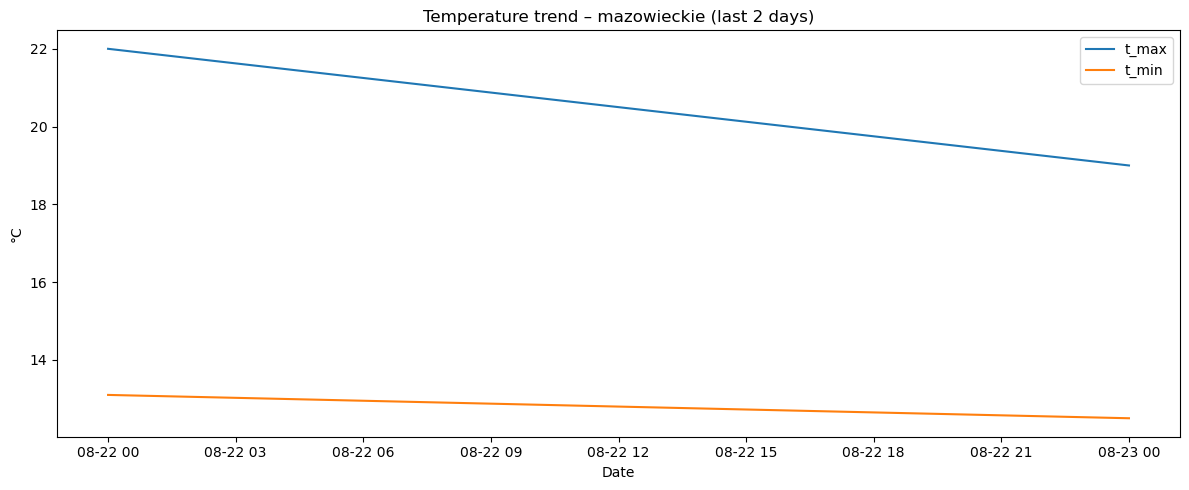

In [7]:
# Time series for a single region (last N days)
REGION = "mazowieckie"
N_DAYS = 30

trend_df = pd.read_sql(
    """
    SELECT date,
           temperature_2m_max, temperature_2m_min,
           precipitation_sum, wind_speed_10m_max
    FROM weather_daily
    WHERE region = ?
    ORDER BY date
    """,
    conn,
    params=[REGION],
)

trend_df["date"] = pd.to_datetime(trend_df["date"], errors="coerce")

# Keep only last N days if you want
trend_df = trend_df.tail(N_DAYS)

# Line chart: max/min temperature over time
plt.figure(figsize=(12, 5))
plt.plot(trend_df["date"], trend_df["temperature_2m_max"], label="t_max")
plt.plot(trend_df["date"], trend_df["temperature_2m_min"], label="t_min")
plt.title(f"Temperature trend – {REGION} (last {len(trend_df)} days)")
plt.xlabel("Date")
plt.ylabel("°C")
plt.legend()
plt.tight_layout()
plt.show()

Ranking: top-5 warmest regions (by max temp) for a day

In [8]:
# Top-5 regions by max temperature for a given day
rank_df = pd.read_sql(
    """
    SELECT region, date, temperature_2m_max
    FROM weather_daily
    WHERE date = ?
    ORDER BY temperature_2m_max DESC
    LIMIT 5
    """,
    conn,
    params=[DATE],
)

rank_df

,region,date,temperature_2m_max
0,lubelskie,2025-08-22,23.70
1,malopolskie,2025-08-22,23.60
2,podlaskie,2025-08-22,23.40
3,swietokrzyskie,2025-08-22,22.40
4,mazowieckie,2025-08-22,22.00


In [9]:
# Close DB connection when you're done
conn.close()